In [1]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, Any

import numpy as np

from qqe.circuit.spec import CircuitSpec, GateSpec
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from qqe.backend import QuimbBackend
from qqe.circuit.families import (
    CliffordBrickwork,
    HaarBrickwork,
    QuansistorBrickwork,
    RandomCircuit,
)
from qqe.circuit.gates import clifford_recipe_unitary
from qqe.experiments.plotting import plot_pennylane_circuit
from qqe.GNN import circuit_spec_to_nx_dag


In [2]:
def bin_theta(theta: float, n_bins:int = 50) -> int:
    t = theta % (2 * np.pi)
    idx = int(np.floor(n_bins * t / (2 * np.pi)))

    return min(max(idx, 0), n_bins - 1)

In [3]:
family_registry = {
    "haar": HaarBrickwork,
    "clifford": CliffordBrickwork,
    "quansistor": QuansistorBrickwork,
    "random": RandomCircuit,
}

In [4]:
GATES = [
    "IN", "OUT",
    "CNOT",                             # random + clifford
    "RX", "RY", "RZ",                   # random
    "H", "S", "T",                      # clifford
    "haar",                             # haar
    "quansistor_X", "quansistor_Y",     # quansistor
]


In [5]:
n_qubits = 8
n_layers = 10
seed = 13

In [6]:
circuit = family_registry["random"]()
circuit_spec = circuit.make_spec(
    n_qubits=n_qubits,
    n_layers=n_layers,
    d=2,
    seed=seed,
)

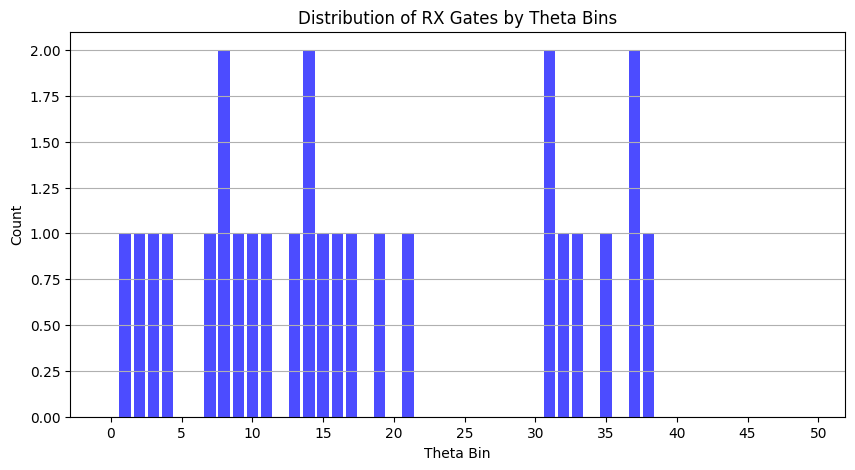

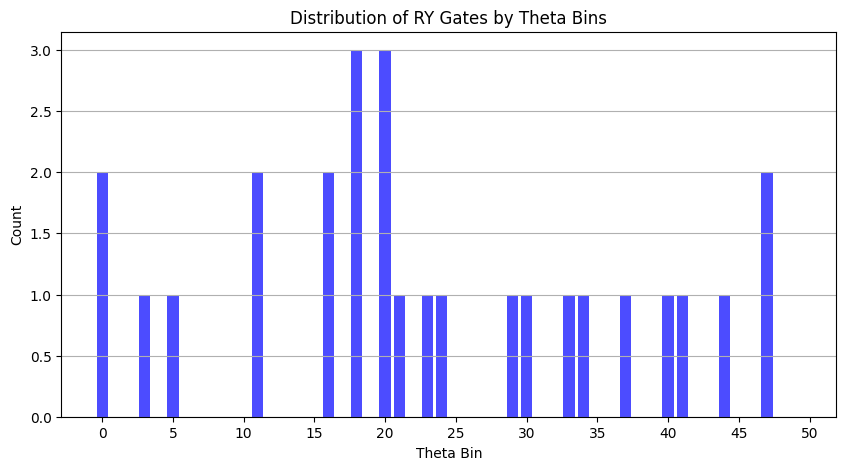

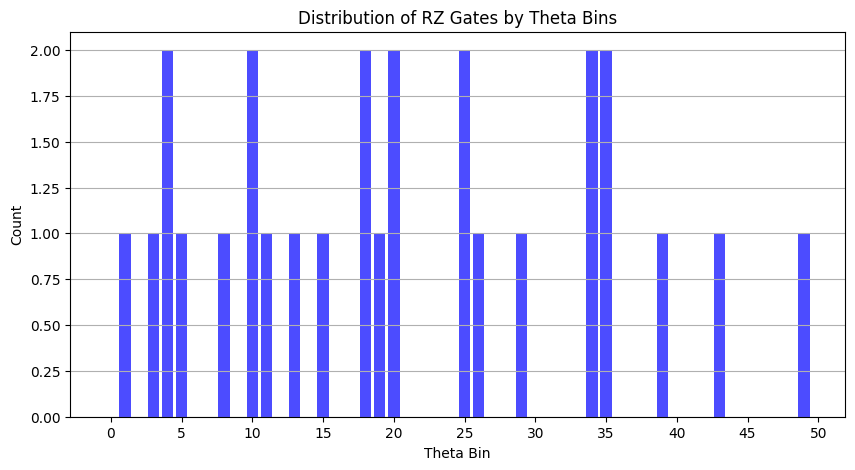

Total CNOT gates: 22


In [7]:
bin_count = {gate: [0] * 50 for gate in ["RX", "RY", "RZ"]}
count_cnot = 0

for gate in circuit_spec.gates:
    theta = gate.params[0] if gate.params else "CNOT"
    #print(theta)
    if isinstance(theta, float):
        idx = bin_theta(theta)
        bin_count[gate.kind][idx] += 1
        # print(f"Gate: {gate.kind}, Theta: {theta}, Bin: {idx}")
    else:
        count_cnot += 1

for gate, counts in bin_count.items():
    plt.figure(figsize=(10, 5))
    plt.bar(range(50), counts, color='blue', alpha=0.7)
    plt.title(f"Distribution of {gate} Gates by Theta Bins")
    plt.xlabel("Theta Bin")
    plt.ylabel("Count")
    plt.xticks(range(0, 51, 5))
    plt.grid(axis='y')
    plt.show()

print(f"Total CNOT gates: {count_cnot}")



In [8]:
def bin_normal(x: float, n_bins: int = 50, clip: float = 4.0) -> int:
    x = float(np.clip(x, -clip, clip))
    u = (x + clip) / (2.0 * clip)  # map to [0,1]
    idx = int(np.floor(n_bins * u))
    return max(0, min(idx, n_bins - 1))

In [9]:
circuit = family_registry["quansistor"]()
circuit_spec = circuit.make_spec(
    n_qubits=n_qubits,
    n_layers=n_layers,
    d=2,
    seed=seed,
)

In [10]:
N_BINS = 50

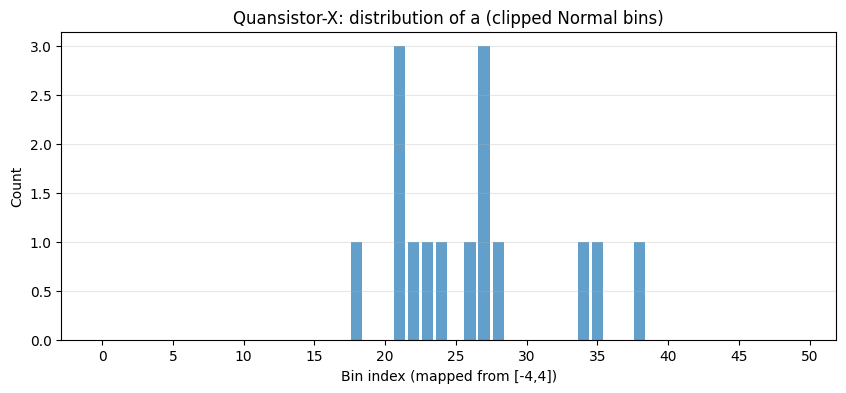

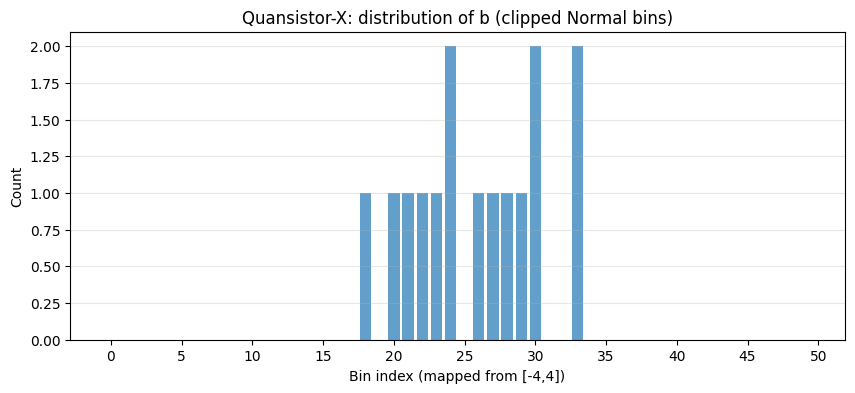

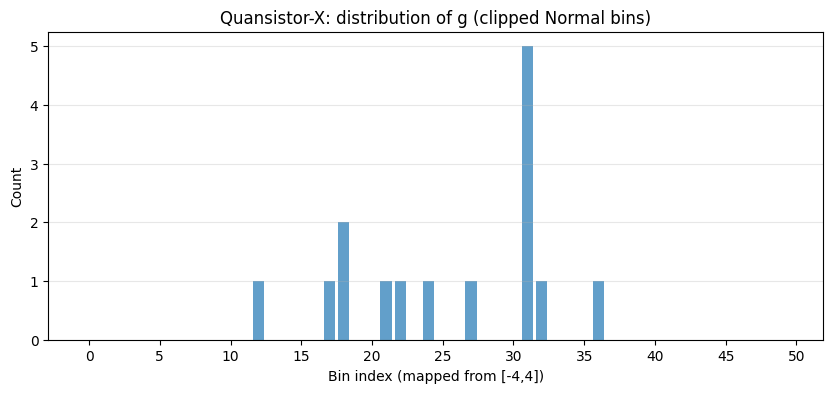

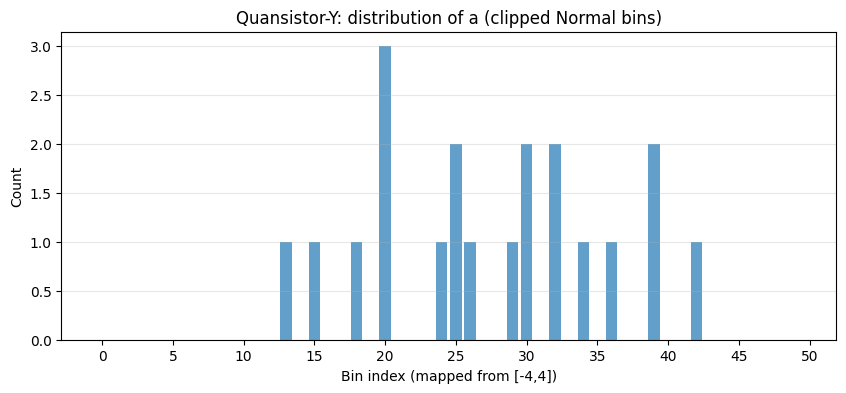

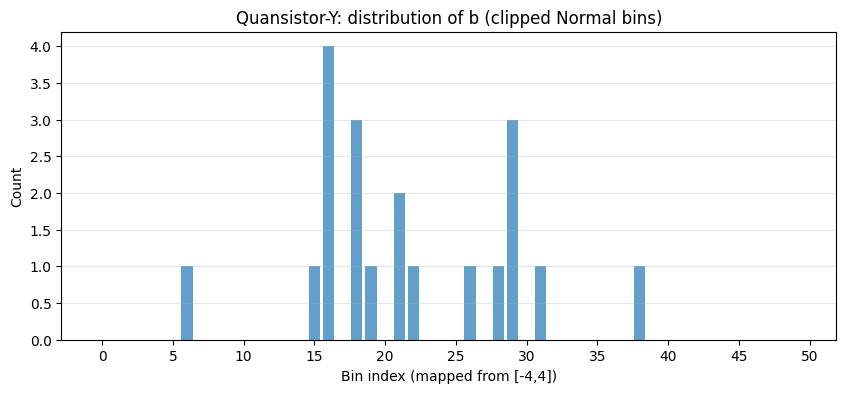

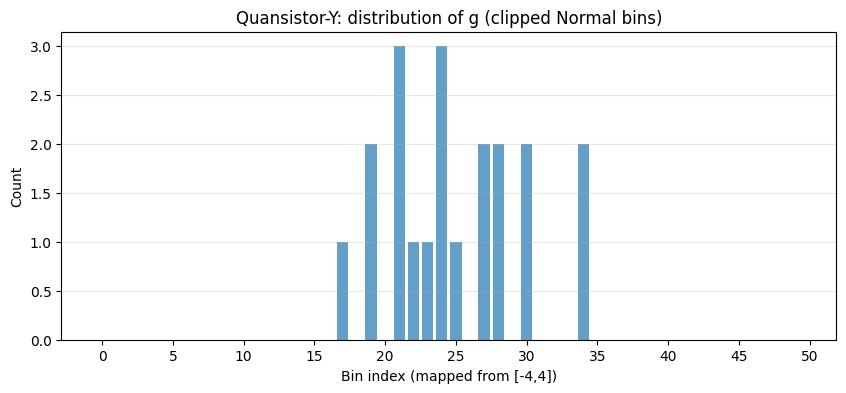

Quansistor counts: {'X': 15, 'Y': 20}


In [11]:
bin_count_quansistor = {
    "X": {"a": [0]*N_BINS, "b": [0]*N_BINS, "g": [0]*N_BINS},
    "Y": {"a": [0]*N_BINS, "b": [0]*N_BINS, "g": [0]*N_BINS},
}
count_quansistor = {"X": 0, "Y": 0}


for gate in circuit_spec.gates:
    #print(gate)
    if gate.kind == "quansistor":
    #     # your params are (a, b, g, axis)
        if not gate.params or len(gate.params) < 4:
            continue  # or reconstruct from seed
        a, b, g, axis = gate.params
        axis = str(axis)  # np.str_ -> python str

        if axis not in ("X", "Y"):
            continue

        count_quansistor[axis] += 1

        bin_count_quansistor[axis]["a"][bin_normal(a)] += 1
        bin_count_quansistor[axis]["b"][bin_normal(b)] += 1
        bin_count_quansistor[axis]["g"][bin_normal(g)] += 1
        continue

for axis in ("X", "Y"):
    for param in ("a", "b", "g"):
        plt.figure(figsize=(10, 4))
        plt.bar(range(N_BINS), bin_count_quansistor[axis][param], alpha=0.7)
        plt.title(f"Quansistor-{axis}: distribution of {param} (clipped Normal bins)")
        plt.xlabel("Bin index (mapped from [-4,4])")
        plt.ylabel("Count")
        plt.xticks(range(0, N_BINS+1, 5))
        plt.grid(axis="y", alpha=0.3)
        plt.show()

print("Quansistor counts:", count_quansistor)

In [12]:
from scipy.stats import norm

def bin_gaussian_quantile(x: float, n_bins: int = N_BINS) -> int:
    """
    Maps x ~ N(0,1) to uniform [0,1] via CDF,
    then discretizes into n_bins.
    """
    u = norm.cdf(float(x))  # Φ(x)
    idx = int(np.floor(n_bins * u))
    return max(0, min(idx, n_bins - 1))

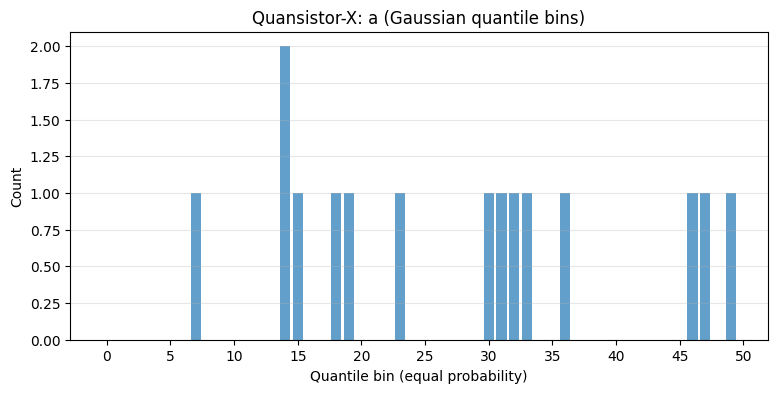

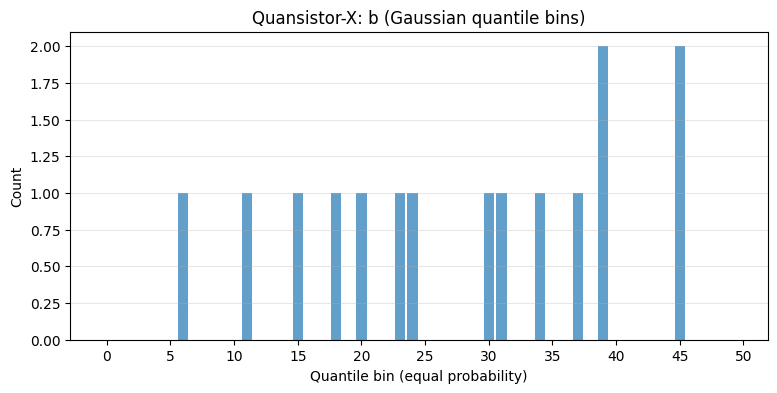

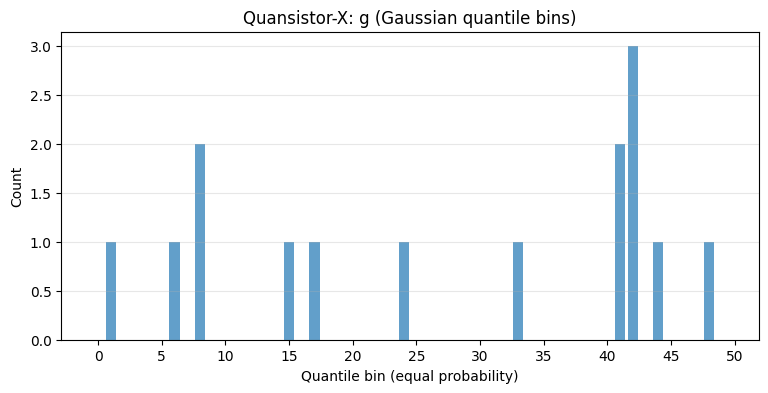

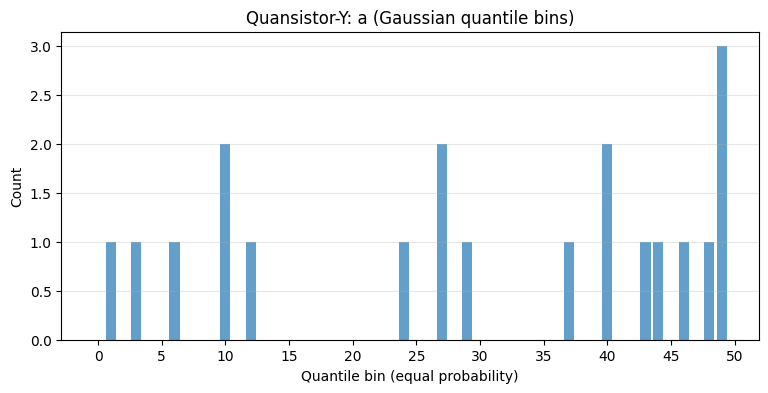

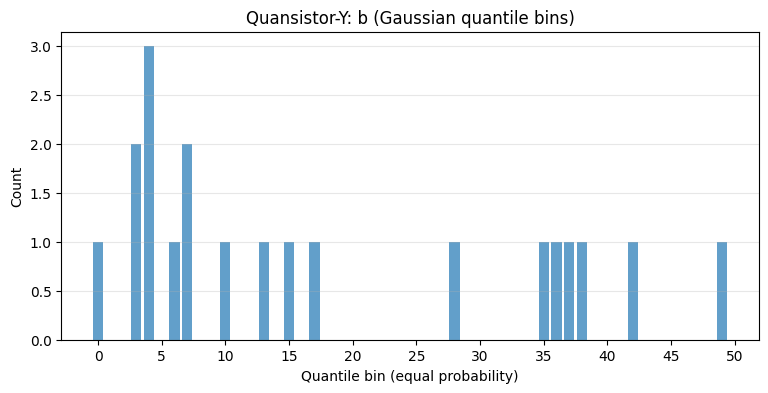

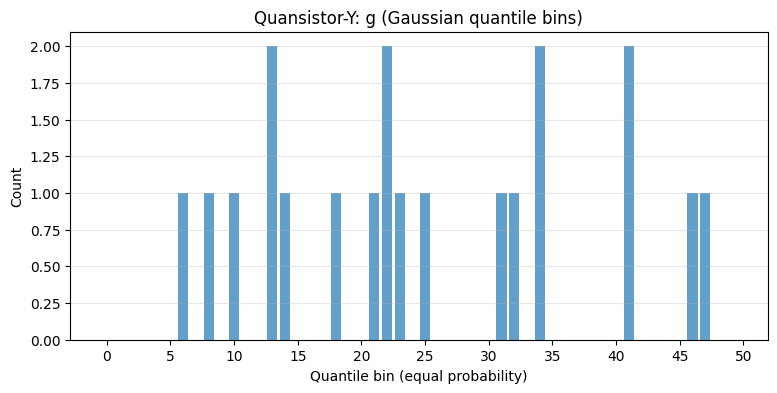

Counts: {'X': 15, 'Y': 20}


In [13]:
q_bins = {
    "X": {"a": [0]*N_BINS, "b": [0]*N_BINS, "g": [0]*N_BINS},
    "Y": {"a": [0]*N_BINS, "b": [0]*N_BINS, "g": [0]*N_BINS},
}

count_quansistor = {"X": 0, "Y": 0}

for gate in circuit_spec.gates:
    if gate.kind != "quansistor":
        continue

    if not gate.params or len(gate.params) < 4:
        raise ValueError("Quansistor gate missing parameters")

    a, b, g, axis = gate.params
    axis = str(axis)

    if axis not in ("X", "Y"):
        continue

    count_quansistor[axis] += 1

    q_bins[axis]["a"][bin_gaussian_quantile(a)] += 1
    q_bins[axis]["b"][bin_gaussian_quantile(b)] += 1
    q_bins[axis]["g"][bin_gaussian_quantile(g)] += 1

for axis in ("X", "Y"):
    for param in ("a", "b", "g"):
        plt.figure(figsize=(9,4))
        plt.bar(range(N_BINS), q_bins[axis][param], alpha=0.7)
        plt.title(f"Quansistor-{axis}: {param} (Gaussian quantile bins)")
        plt.xlabel("Quantile bin (equal probability)")
        plt.ylabel("Count")
        plt.xticks(range(0, N_BINS+1, 5))
        plt.grid(axis="y", alpha=0.3)
        plt.show()

print("Counts:", count_quansistor)

In [14]:
circuit = family_registry["haar"]()
circuit_spec = circuit.make_spec(
    n_qubits=n_qubits,
    n_layers=n_layers,
    d=2,
    seed=seed,
)

In [15]:
def haar_unitary_from_seed(seed: int, dim: int) -> np.ndarray:
    """Reproduce your haar_unitary_gate(d, rng) deterministically."""
    rng = np.random.default_rng(seed)
    a = rng.normal(size=(dim, dim))
    b = rng.normal(size=(dim, dim))
    Z = a + 1j * b
    Q, R = np.linalg.qr(Z)
    # make Q Haar by fixing phases with diag of R
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(dim)])
    U = Q @ Lambda
    return np.asarray(U, dtype=complex)

def op_schmidt_entropy_twoqubit(U: np.ndarray) -> float:
    """
    Operator-Schmidt entropy across (qubit 1) | (qubit 2) for a 4x4 two-qubit unitary.
    Returns entropy in nats.
    """
    # U is 4x4 with basis |o1 o2> rows, |i1 i2> cols
    T = U.reshape(2, 2, 2, 2)          # o1,o2,i1,i2
    M = np.transpose(T, (0, 2, 1, 3))  # o1,i1,o2,i2
    M = M.reshape(4, 4)                # (o1,i1) vs (o2,i2)
    s = np.linalg.svd(M, compute_uv=False)
    p = (s**2) / np.sum(s**2)
    p = p[p > 0]
    return float(-np.sum(p * np.log(p)))

def bin_unit_interval(x: float, n_bins: int = N_BINS) -> int:
    x = float(np.clip(x, 0.0, 1.0))
    idx = int(np.floor(n_bins * x))
    return max(0, min(idx, n_bins - 1))

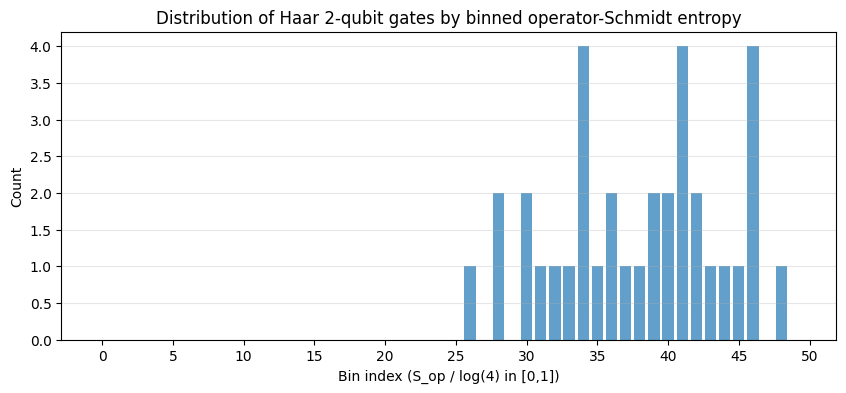

Total haar gates: 35


In [16]:
haar_bins = [0] * N_BINS
count_haar = 0

for gate in circuit_spec.gates:
    dim = gate.d ** len(gate.wires)   # 4
    U = haar_unitary_from_seed(gate.seed, dim=dim)

    S = op_schmidt_entropy_twoqubit(U)
    S_norm = S / np.log(4.0)
    idx = bin_unit_interval(S_norm, N_BINS)

    haar_bins[idx] += 1
    count_haar += 1

# plot
plt.figure(figsize=(10, 4))
plt.bar(range(N_BINS), haar_bins, alpha=0.7)
plt.title("Distribution of Haar 2-qubit gates by binned operator-Schmidt entropy")
plt.xlabel("Bin index (S_op / log(4) in [0,1])")
plt.ylabel("Count")
plt.xticks(range(0, N_BINS+1, 5))
plt.grid(axis="y", alpha=0.3)
plt.show()

print("Total haar gates:", count_haar)

In [17]:
from qqe.circuit.patterns import TdopingRules

In [18]:
circuit = family_registry["clifford"]()
circuit_spec = circuit.make_spec(
    n_qubits=n_qubits,
    n_layers=n_layers,
    d=2,
    seed=seed,
    tdoping=TdopingRules(count=2*n_layers, per_layer=2)
)

In [19]:
import re

_DECOMP_RE = re.compile(r"decomp_([^⊗]+)⊗([^+]+)\+CNOT")

def parse_clifford_decomp(tags: tuple[str, ...]) -> tuple[str, str] | None:
    """
    Returns (Ua, Ub) in {"I","H","S"} parsed from a 'decomp_' tag.
    """
    for t in tags:
        if not isinstance(t, str):
            continue
        m = _DECOMP_RE.match(t)
        if m:
            return m.group(1), m.group(2)
    return None

In [20]:
from collections import Counter

def count_clifford_T(circuit_spec) -> Counter:
    counts = Counter({"I":0, "H":0, "S":0, "CNOT":0, "T":0})

    for g in circuit_spec.gates:
        if g.kind == "T":
            counts["T"] += 1

        elif g.kind == "CNOT":
            counts["CNOT"] += 1

        elif g.kind == "clifford":
            decomp = parse_clifford_decomp(tuple(g.tags))
            if decomp is None:
                raise ValueError(f"Missing decomp tag in clifford gate tags={g.tags}")
            Ua, Ub = decomp
            if Ua not in ("I","H","S") or Ub not in ("I","H","S"):
                raise ValueError(f"Unexpected decomp {Ua}⊗{Ub}")
            counts[Ua] += 1
            counts[Ub] += 1
            counts["CNOT"] += 1  # because your clifford macro always includes CNOT

        else:
            # ignore other families if present, or add as needed
            pass

    return counts

In [21]:
counts = count_clifford_T(circuit_spec)
print("Clifford counts:", counts)

Clifford counts: Counter({'CNOT': 35, 'T': 18, 'I': 0, 'H': 0, 'S': 0})


In [22]:
UA_SET = ("I","H","S")
UA2IDX = {k:i for i,k in enumerate(UA_SET)}

def clifford_node_features(g, n_qubits: int) -> np.ndarray:
    """
    Node embedding for a clifford macro node.
    """
    # gate type: [clifford, T, OTHER]
    gate_types = ("clifford", "T", "OTHER")
    gt2i = {k:i for i,k in enumerate(gate_types)}
    v_gate = np.zeros(len(gate_types), dtype=np.float32)
    v_gate[gt2i["clifford"]] = 1.0

    v_q = np.zeros(n_qubits, dtype=np.float32)
    for w in g.wires:
        v_q[w] = 1.0

    # decomposition
    UaUb = parse_clifford_decomp(tuple(g.tags))
    if UaUb is None:
        raise ValueError("Missing decomp tag")
    Ua, Ub = UaUb

    v_Ua = np.zeros(3, dtype=np.float32)
    v_Ub = np.zeros(3, dtype=np.float32)
    v_Ua[UA2IDX[Ua]] = 1.0
    v_Ub[UA2IDX[Ub]] = 1.0

    return np.concatenate([v_gate, v_q, v_Ua, v_Ub])

In [23]:
def T_node_features(g, n_qubits: int) -> np.ndarray:
    gate_types = ("clifford", "T", "OTHER")
    gt2i = {k:i for i,k in enumerate(gate_types)}
    v_gate = np.zeros(len(gate_types), dtype=np.float32)
    v_gate[gt2i["T"]] = 1.0

    v_q = np.zeros(n_qubits, dtype=np.float32)
    v_q[g.wires[0]] = 1.0
    # no Ua/Ub for T -> zeros
    return np.concatenate([v_gate, v_q, np.zeros(3, dtype=np.float32), np.zeros(3, dtype=np.float32)])

In [24]:
def build_X_macro(spec) -> np.ndarray:
    rows = []
    for g in spec.gates:
        if g.kind == "clifford":
            rows.append(clifford_node_features(g, spec.n_qubits))
        elif g.kind == "T":
            rows.append(T_node_features(g, spec.n_qubits))
        else:
            # optionally map others to OTHER
            pass
    return np.stack(rows, axis=0)

In [25]:
X = build_X_macro(circuit_spec)

In [26]:
for gate in circuit_spec.gates:
    print(gate.kind, gate.tags)

I ('layer', 'L0', 'clifford_1q', 'wire_0', 'ua_I')
S ('layer', 'L0', 'clifford_1q', 'wire_1', 'ub_S')
CNOT ('layer', 'L0', 'clifford_2q', 'wire_0_1')
H ('layer', 'L0', 'clifford_1q', 'wire_2', 'ua_H')
S ('layer', 'L0', 'clifford_1q', 'wire_3', 'ub_S')
CNOT ('layer', 'L0', 'clifford_2q', 'wire_2_3')
I ('layer', 'L0', 'clifford_1q', 'wire_4', 'ua_I')
I ('layer', 'L0', 'clifford_1q', 'wire_5', 'ub_I')
CNOT ('layer', 'L0', 'clifford_2q', 'wire_4_5')
S ('layer', 'L0', 'clifford_1q', 'wire_6', 'ua_S')
I ('layer', 'L0', 'clifford_1q', 'wire_7', 'ub_I')
CNOT ('layer', 'L0', 'clifford_2q', 'wire_6_7')
T ('layer', 'L0', 'T-gate', 'wire_3')
T ('layer', 'L0', 'T-gate', 'wire_4')
I ('layer', 'L1', 'clifford_1q', 'wire_1', 'ua_I')
H ('layer', 'L1', 'clifford_1q', 'wire_2', 'ub_H')
CNOT ('layer', 'L1', 'clifford_2q', 'wire_1_2')
S ('layer', 'L1', 'clifford_1q', 'wire_3', 'ua_S')
S ('layer', 'L1', 'clifford_1q', 'wire_4', 'ub_S')
CNOT ('layer', 'L1', 'clifford_2q', 'wire_3_4')
H ('layer', 'L1', 'cliff

In [27]:
from dataclasses import replace

def expand_clifford_macro_to_primitives(spec):
    """
    Returns a new CircuitSpec where each 'clifford' macro gate becomes:
      Ua on wire a, Ub on wire b, CNOT on (a,b)
    Keeps T gates as-is.
    """
    new_gates = []
    for g in spec.gates:
        if g.kind != "clifford":
            new_gates.append(g)
            continue

        UaUb = parse_clifford_decomp(tuple(g.tags))
        if UaUb is None:
            raise ValueError("Missing decomp tag")
        Ua, Ub = UaUb
        a, b = g.wires

        # 1q gates (note: these are unparameterized in your _ONEQ)
        new_gates.append(replace(g, kind=Ua, wires=(a,), params=(), tags=g.tags + (f"expanded_from_clifford",)))
        new_gates.append(replace(g, kind=Ub, wires=(b,), params=(), tags=g.tags + (f"expanded_from_clifford",)))

        # the CNOT (direction matches your clifford_recipe_unitary definition)
        new_gates.append(replace(g, kind="CNOT", wires=(a,b), params=(), tags=g.tags + (f"expanded_from_clifford",)))

    return replace(spec, gates=tuple(new_gates))

In [28]:
expanded_spec = expand_clifford_macro_to_primitives(circuit_spec)

In [29]:
expanded_spec

CircuitSpec(n_qubits=8, n_layers=10, d=2, family='clifford', connectivity='line', pattern='brickwork', global_seed=13, gates=(GateSpec(kind='I', wires=(0,), d=2, seed=15534763970152864265, tags=('layer', 'L0', 'clifford_1q', 'wire_0', 'ua_I'), params=()), GateSpec(kind='S', wires=(1,), d=2, seed=15534763970152864265, tags=('layer', 'L0', 'clifford_1q', 'wire_1', 'ub_S'), params=()), GateSpec(kind='CNOT', wires=(0, 1), d=2, seed=15534763970152864265, tags=('layer', 'L0', 'clifford_2q', 'wire_0_1'), params=()), GateSpec(kind='H', wires=(2,), d=2, seed=14532951774570812326, tags=('layer', 'L0', 'clifford_1q', 'wire_2', 'ua_H'), params=()), GateSpec(kind='S', wires=(3,), d=2, seed=14532951774570812326, tags=('layer', 'L0', 'clifford_1q', 'wire_3', 'ub_S'), params=()), GateSpec(kind='CNOT', wires=(2, 3), d=2, seed=14532951774570812326, tags=('layer', 'L0', 'clifford_2q', 'wire_2_3'), params=()), GateSpec(kind='I', wires=(4,), d=2, seed=6720343910181812350, tags=('layer', 'L0', 'clifford_1q'